# Project: Investigate Soccer Data
## Specifically: Answer questions regarding what team attributes make a successful team
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

I chose the soccer data set. I have two daughters that both play soccer regularly and I thought this data set would be a good challenge with a topic that I have a little familiarity with.

The initial data gathering included downloading the SQLite file then migrating the data from sqlite to PostgreSQL (I am more comfortable working in SQL). From there I initially thought I would look at analyzing either penalty kicks or free kicks, but the data for both teams and players didn't seem very helpful in that regard. I decided to change up and look at team attributes of a successful team. There was ample data on team attributes and season by season data.


> <li><a href="#qone">Research Question 1: Are there specific team attributes that "successful" teams possess</a></li>

As an additional question I thought I would look at several teams year by year to see if the data panned out, e.g. if a team changed some aspect of an attribute that was identified as contributing to success would it have an effect on their win/loss/draw records.


> <li><a href="#qtwo">Research Question 2: If a characteristic identified above (in the Chance or Defense sections) changes for a team from season to season is there a corresponding change in their success?</a></li>

To gather this data I started by creating a table called "records" in the PostGreSQL database. The records table included team name, country, season, information about the teams playing (home and away), scores, and the winning team, losing team, or a draw flag if the game was a draw. I created the table with the following queries in PostGRESql:

```sql
-- Create Records Table
CREATE TABLE records
AS
SELECT
    id,
    country_id,
    league_id,
    season,
    date,
    match_api_id,
    home_team_api_id,
    away_team_api_id,
    home_team_goal,
    away_team_goal
FROM
    match;
    
-- Add draw, winning_team, losing_team columns
ALTER TABLE records
    ADD COLUMN draw integer,
    ADD COLUMN winning_team integer,
    ADD COLUMN losing_team integer;
    
-- Set Draws flag if the score was even
UPDATE
    records
SET
    draw = 1
WHERE
    home_team_goal = away_team_goal;

-- Set the winning and losing teams if the home team wins
UPDATE
    records
SET
    winning_team = home_team_api_id,
    losing_team = away_team_api_id
WHERE
    home_team_goal > away_team_goal;

--Set the winning team if the home team loses
UPDATE
    records
SET
    winning_team = away_team_api_id,
    losing_team = home_team_api_id
WHERE
    home_team_goal < away_team_goal;
```

I could then roll these up into a teamdata csv using the following query to merge team,  team_attributes and win/loss/draw records 

```sql
SELECT tm.team_long_name as "team_name",
	EXTRACT(YEAR FROM ta.date) as "season",
	ta.buildupplayspeed,
    ta.buildupplaydribbling,
    ta.buildupplaydribblingclass,
    ta.buildupplaypassing,
    ta.buildupplaypassingclass,
    ta.buildupplaypositioningclass,
    ta.chancecreationpassing,
    ta.chancecreationpassingclass,
    ta.chancecreationcrossing,
    ta.chancecreationcrossingclass,
    ta.chancecreationshooting,
    ta.chancecreationshootingclass,
    ta.chancecreationpositioningclass,
    ta.defencepressure,
    ta.defencepressureclass,
    ta.defenceaggression,
    ta.defenceaggressionclass,
    ta.defenceteamwidth,
    ta.defenceteamwidthclass,
    ta.defencedefenderlineclass,
	(SELECT count(*) FROM public."records" rec WHERE draw = 1 AND EXTRACT(YEAR FROM rec.date) = EXTRACT(YEAR FROM ta.date)
	 AND (rec.home_team_api_id = tm.team_api_id OR rec.away_team_api_id = tm.team_api_id) ) as "draws",
	(SELECT count(rec1.winning_team) FROM public."records" rec1 WHERE EXTRACT(YEAR FROM rec1.date) = EXTRACT(YEAR FROM ta.date)
	 AND rec1.winning_team = tm.team_api_id) AS "wins",
	(SELECT count(rec2.losing_team) FROM public."records" rec2 WHERE EXTRACT(YEAR FROM rec2.date) = EXTRACT(YEAR FROM ta.date)
	 AND rec2.losing_team = tm.team_api_id) AS "losses"
FROM public."Team" tm
JOIN public."team_attributes" ta ON ta.team_api_id = tm.team_api_id;
```

I exported the results of the query above to teamdata.csv.

Next I needed to define what a successful team was. I started with more wins than losses but after second thought I planned on using the top 20% based on maximum wins. I will delve into this further below.

> ***NOTE*** I have uploaded a full PostGRESql dump file with the tables I worked with (from the original SQLite) as well as only the records table (in as single dumpfile) and the teamdata.csv file to my github located at: https://github.com/cherrde/data-analyst-project-2


In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


<a id='wrangling'></a>
## Data Wrangling
### General Properties

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.

dfteamdata = pd.read_csv('teamdata.csv')

dfteamdata.head()

,team_name,season,buildupplayspeed,buildupplaydribbling,buildupplaydribblingclass,buildupplaypassing,buildupplaypassingclass,buildupplaypositioningclass,chancecreationpassing,chancecreationpassingclass,...,defencepressure,defencepressureclass,defenceaggression,defenceaggressionclass,defenceteamwidth,defenceteamwidthclass,defencedefenderlineclass,draws,wins,losses
0,FC Aarau ...,2010,60,NaN,Little ...,50,Mixed ...,Organised ...,60,Normal ...,...,50,Medium ...,55,Press ...,45,Normal ...,Cover ...,1,5,12
1,FC Aarau ...,2014,52,48.0,Normal ...,56,Mixed ...,Organised ...,54,Normal ...,...,47,Medium ...,44,Press ...,54,Normal ...,Cover ...,10,10,17
2,FC Aarau ...,2015,47,41.0,Normal ...,54,Mixed ...,Organised ...,54,Normal ...,...,47,Medium ...,44,Press ...,54,Normal ...,Cover ...,5,3,10
3,Aberdeen ...,2010,70,NaN,Little ...,70,Long ...,Organised ...,70,Risky ...,...,60,Medium ...,70,Double ...,70,Wide ...,Cover ...,6,11,23
4,Aberdeen ...,2011,47,NaN,Little ...,52,Mixed ...,Organised ...,53,Normal ...,...,47,Medium ...,47,Press ...,52,Normal ...,Cover ...,10,11,20


In [3]:
# Show data concerning the dataframe, useful later for nulls, for example as we see in buildupplaydribbling

dfteamdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
team_name                         1458 non-null object
season                            1458 non-null int64
buildupplayspeed                  1458 non-null int64
buildupplaydribbling              489 non-null float64
buildupplaydribblingclass         1458 non-null object
buildupplaypassing                1458 non-null int64
buildupplaypassingclass           1458 non-null object
buildupplaypositioningclass       1458 non-null object
chancecreationpassing             1458 non-null int64
chancecreationpassingclass        1458 non-null object
chancecreationcrossing            1458 non-null int64
chancecreationcrossingclass       1458 non-null object
chancecreationshooting            1458 non-null int64
chancecreationshootingclass       1458 non-null object
chancecreationpositioningclass    1458 non-null object
defencepressure                   1458 non-null int64
defencepressureclass

In [4]:
# View dataframe shape

dfteamdata.shape

(1458, 25)

In [5]:
# View information about the numerical data in the dataframe, means, etc.

dfteamdata.describe()

,season,buildupplayspeed,buildupplaydribbling,buildupplaypassing,chancecreationpassing,chancecreationcrossing,chancecreationshooting,defencepressure,defenceaggression,defenceteamwidth,draws,wins,losses
count,1458.000000,1458.000000,489.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,2012.506859,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,6.563100,9.694787,9.551440
std,1.709201,11.545869,9.678290,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,4.352887,7.352819,6.164116
min,2010.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,0.000000,0.000000,0.000000
25%,2011.000000,45.000000,42.000000,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,4.000000,3.000000,5.000000
50%,2013.000000,52.000000,49.000000,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,7.000000,10.000000,10.000000
75%,2014.000000,62.000000,55.000000,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,10.000000,14.000000,14.000000
max,2015.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,19.000000,33.000000,28.000000


### Data Cleaning
The first thing I noted is that the buildupplaydribbling is the only field with null data, there is a buildupplaydribblingclass text field, though. I would like to use the mean of this field which is not 
null on any values as the basis for filling the numeric value. So if the value for buildupplaydribblingclass 
is "Little", I'll use the mean of that value to fill the null values.

In [6]:
# Fill in null values with mean of the numeric values found in the equivalent class string field

dfteamdata.buildupplaydribbling = (dfteamdata['buildupplaydribbling'].fillna(dfteamdata.groupby("buildupplaydribblingclass")['buildupplaydribbling'].transform('mean')))

In [7]:
# Confirm the data has been filled

dfteamdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
team_name                         1458 non-null object
season                            1458 non-null int64
buildupplayspeed                  1458 non-null int64
buildupplaydribbling              1458 non-null float64
buildupplaydribblingclass         1458 non-null object
buildupplaypassing                1458 non-null int64
buildupplaypassingclass           1458 non-null object
buildupplaypositioningclass       1458 non-null object
chancecreationpassing             1458 non-null int64
chancecreationpassingclass        1458 non-null object
chancecreationcrossing            1458 non-null int64
chancecreationcrossingclass       1458 non-null object
chancecreationshooting            1458 non-null int64
chancecreationshootingclass       1458 non-null object
chancecreationpositioningclass    1458 non-null object
defencepressure                   1458 non-null int64
defencepressureclas

In [8]:
# The builduplaydribbling is a float while other numerics are integers. The integer should be fine. 

dfteamdata['buildupplaydribbling'] = dfteamdata['buildupplaydribbling'].astype(int)

In [9]:
# One more change. I don't think we'll need the string "class" fields any longer. We can drop them

dfteamdata.drop(dfteamdata.columns[dfteamdata.columns.str.contains('class')], axis=1, inplace = True)

# And see our dataframe's information
dfteamdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 14 columns):
team_name                 1458 non-null object
season                    1458 non-null int64
buildupplayspeed          1458 non-null int64
buildupplaydribbling      1458 non-null int32
buildupplaypassing        1458 non-null int64
chancecreationpassing     1458 non-null int64
chancecreationcrossing    1458 non-null int64
chancecreationshooting    1458 non-null int64
defencepressure           1458 non-null int64
defenceaggression         1458 non-null int64
defenceteamwidth          1458 non-null int64
draws                     1458 non-null int64
wins                      1458 non-null int64
losses                    1458 non-null int64
dtypes: int32(1), int64(12), object(1)
memory usage: 153.9+ KB


In [10]:
# And see what our data looks like
dfteamdata.head()

,team_name,season,buildupplayspeed,buildupplaydribbling,buildupplaypassing,chancecreationpassing,chancecreationcrossing,chancecreationshooting,defencepressure,defenceaggression,defenceteamwidth,draws,wins,losses
0,FC Aarau ...,2010,60,30,50,60,65,55,50,55,45,1,5,12
1,FC Aarau ...,2014,52,48,56,54,63,64,47,44,54,10,10,17
2,FC Aarau ...,2015,47,41,54,54,63,64,47,44,54,5,3,10
3,Aberdeen ...,2010,70,30,70,70,70,70,60,70,70,6,11,23
4,Aberdeen ...,2011,47,30,52,53,48,52,47,47,52,10,11,20


In [11]:
# I've noted there is some whitespace in the team names. So we should strip that out

dfteamdata['team_name']=dfteamdata['team_name'].str.strip()
dfteamdata.head()

,team_name,season,buildupplayspeed,buildupplaydribbling,buildupplaypassing,chancecreationpassing,chancecreationcrossing,chancecreationshooting,defencepressure,defenceaggression,defenceteamwidth,draws,wins,losses
0,FC Aarau,2010,60,30,50,60,65,55,50,55,45,1,5,12
1,FC Aarau,2014,52,48,56,54,63,64,47,44,54,10,10,17
2,FC Aarau,2015,47,41,54,54,63,64,47,44,54,5,3,10
3,Aberdeen,2010,70,30,70,70,70,70,60,70,70,6,11,23
4,Aberdeen,2011,47,30,52,53,48,52,47,47,52,10,11,20


<a id='eda'></a>
## Exploratory Data Analysis

<a id='qone'></a>
### Research Question 1: Are there specific team attributes that "successful" teams possess

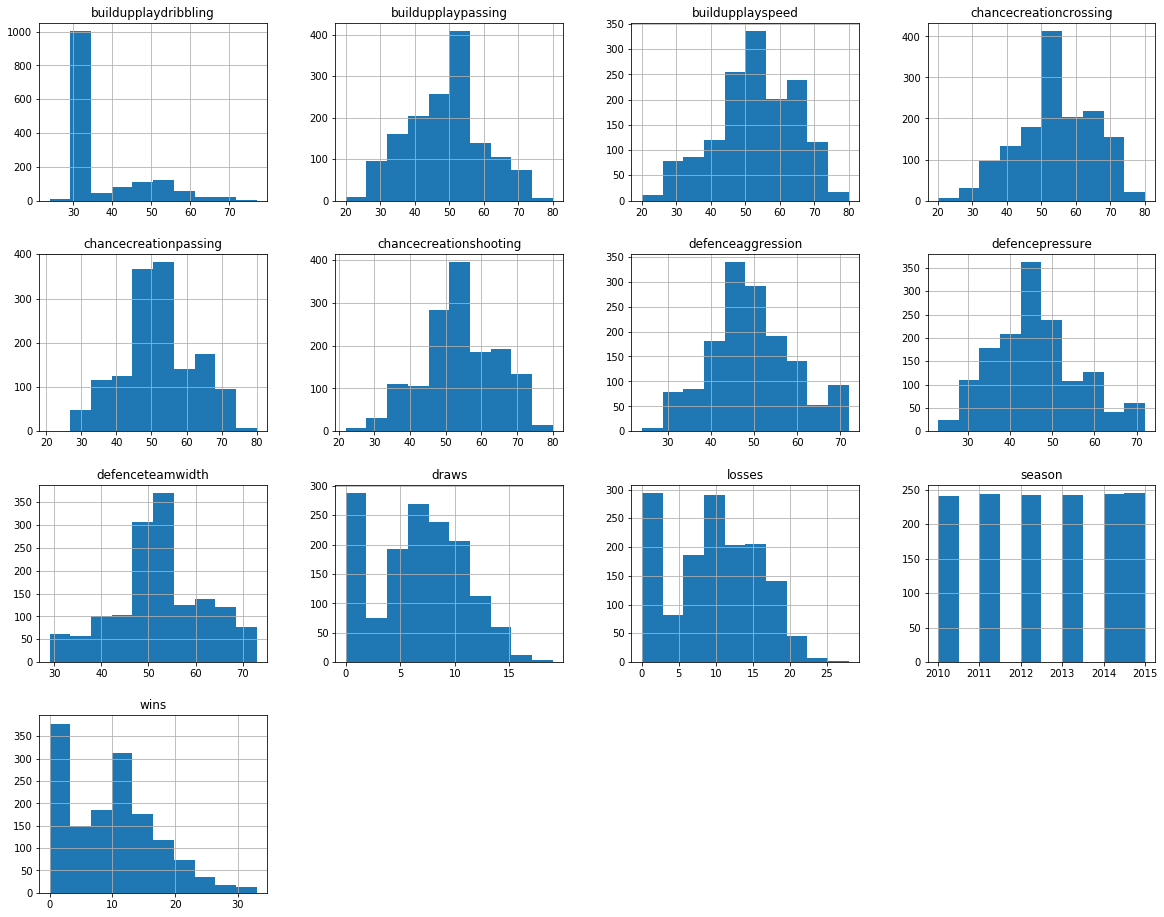

In [12]:
# Just get a feel of the distribution of data
dfteamdata.hist(figsize=(20, 16 ));

Here we will now define what a "successful" team is. I felt the top 80% of teams (1 in 5) with most wins seemd like 
a good place to cut off. I previously when exploring the data saw the 75th percentile was about 14 wins. I'd like
to use a slightly higher number.


In [13]:
# Create a column in the dataframe to indicate whether a team is successful or not, for this we'll say the top 20%
# of teams can be defined as successful and will use that win number using numpy's percentile function to get that

dfteamdata['success'] = np.where(dfteamdata['wins'] > np.percentile(dfteamdata['wins'], 80), True, False)
dfteamdata.head()

,team_name,season,buildupplayspeed,buildupplaydribbling,buildupplaypassing,chancecreationpassing,chancecreationcrossing,chancecreationshooting,defencepressure,defenceaggression,defenceteamwidth,draws,wins,losses,success
0,FC Aarau,2010,60,30,50,60,65,55,50,55,45,1,5,12,False
1,FC Aarau,2014,52,48,56,54,63,64,47,44,54,10,10,17,False
2,FC Aarau,2015,47,41,54,54,63,64,47,44,54,5,3,10,False
3,Aberdeen,2010,70,30,70,70,70,70,60,70,70,6,11,23,False
4,Aberdeen,2011,47,30,52,53,48,52,47,47,52,10,11,20,False


In [14]:
# Define successful as the success column is True, additionally define therest as False

successful = dfteamdata.success == True
therest = dfteamdata.success == False

#### Next Steps
For the next steps I'm going to view histograms comparing the distribution of each of the nine attributes. Since we're using the top 20% of teams, I feel the density probability will give me better insight to view the distribution of values on similar footings. I'll be comparing Successful teams with the Rest.

#### Build Up Play Speed
The first attribute below looks promising. The successful teams are skewed more to the right

Lets look at the other attributes

In [15]:
# Create a function to view score data

def myHist(df, xVar, grpVar):
    df.query(grpVar)[xVar].hist(figsize=(16,8),alpha=0.5,label='Successful', density=True)
    df.query(f"~{grpVar}")[xVar].hist(alpha=0.5,label='The Rest', density=True)
    plt.ylabel('Probability Density', fontsize=14)
    plt.xlabel(f'{xVar}', fontsize=14)
    plt.title(f'{xVar} Density for Successful and Non-Successful Teams'.title(), fontsize=16, weight="bold")
    plt.legend()
 

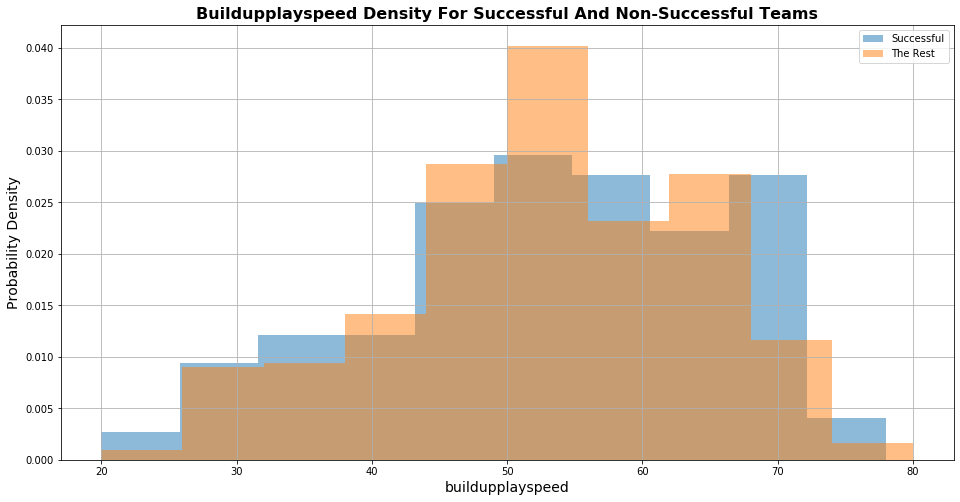

In [16]:
# Plot a histogram of each numeric datapoint. I am using density to show probality an value will end up in a bin 

myHist(dfteamdata, 'buildupplayspeed', 'success')

#### Build Up Play Dribbling Score

This looks less promising, while the successful teams have more higher scores, there's still significant overlap
in the low scores

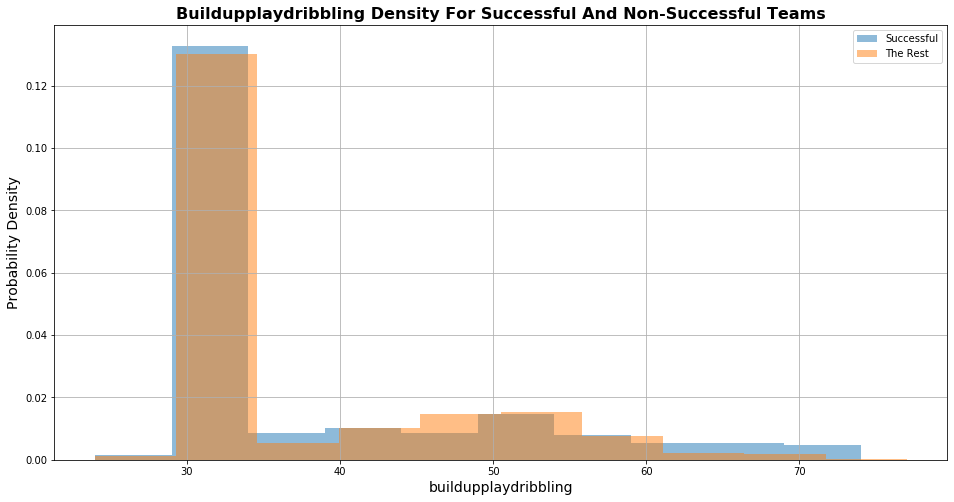

In [17]:
myHist(dfteamdata, 'buildupplaydribbling', 'success')

#### Build Up Play Passing Score

This would seem to indicate that lower Build Up Play Passing scores correlate to success. I'm not sure that is a valid 
line of inquiry

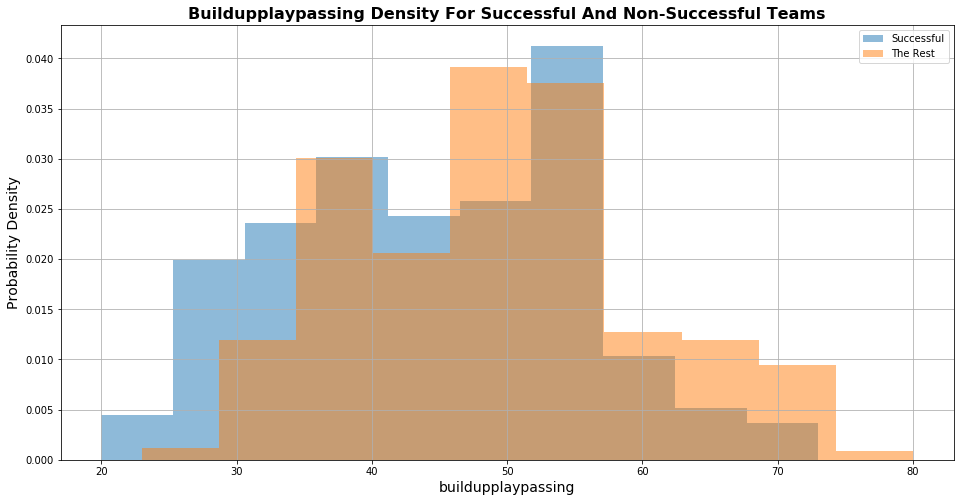

In [18]:
myHist(dfteamdata, 'buildupplaypassing', 'success')

#### Chance Creation Crossing Score

Seems very similar, but there are some strengths for the successful teams possibly

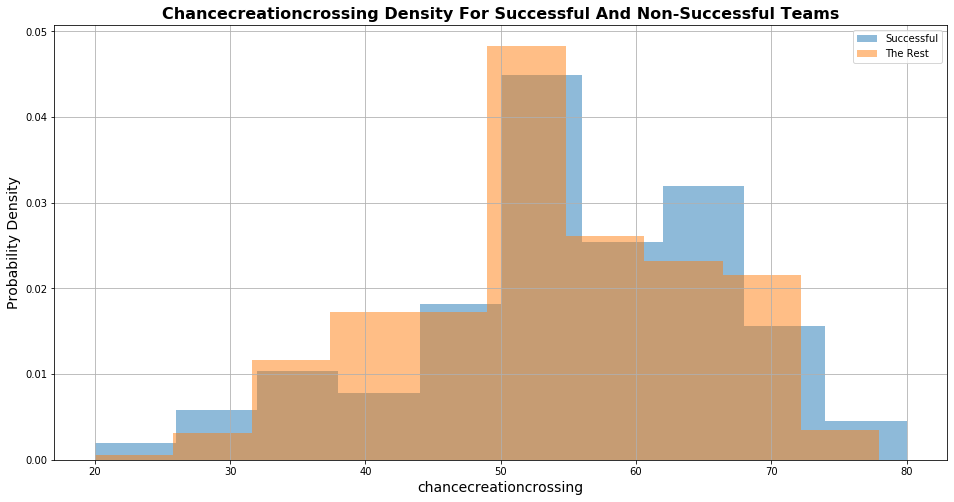

In [19]:
myHist(dfteamdata, 'chancecreationcrossing', 'success')

#### Chance Creation Passing Score

Seems like there might some correlation here.

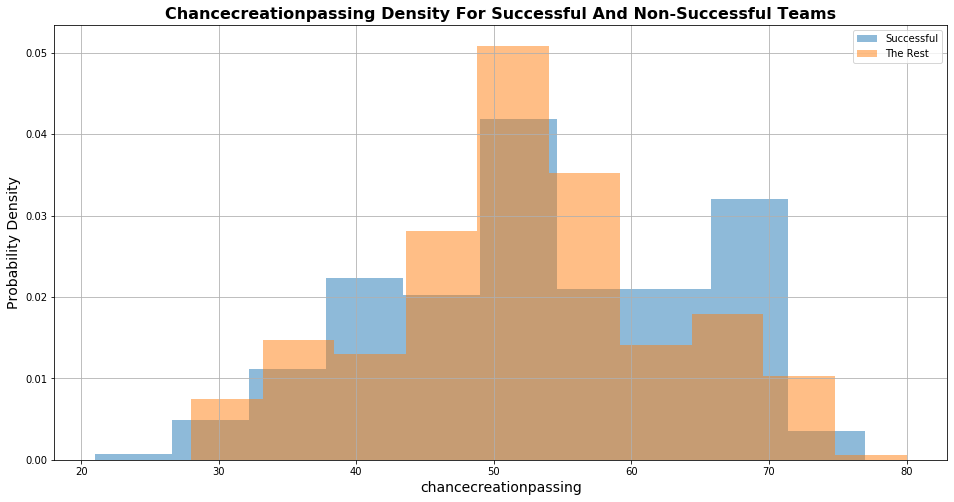

In [20]:
myHist(dfteamdata, 'chancecreationpassing', 'success')

#### Chance Creation Shooting

Seems, again, that there is a higher concentration of high shooting scores in successful teams

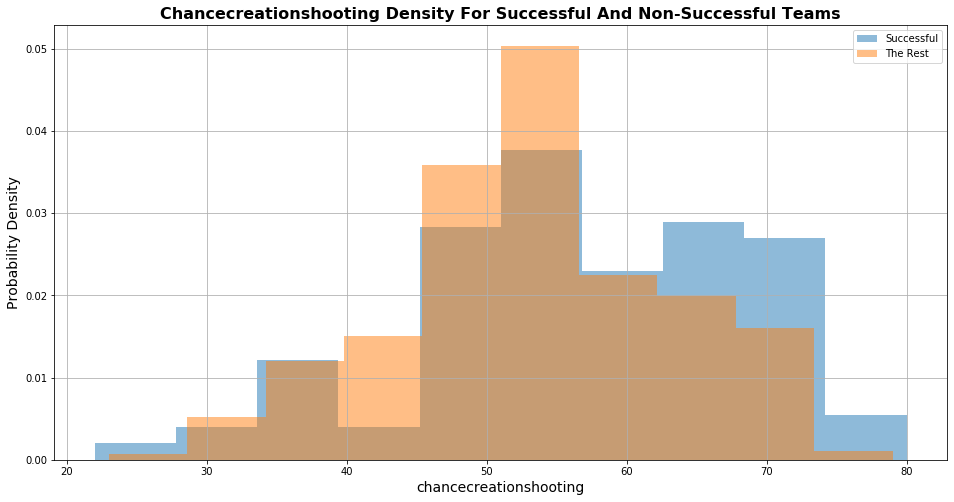

In [21]:
myHist(dfteamdata, 'chancecreationshooting', 'success')

#### Defense Aggression Score

Seems to be some slightly higher scores amongst the successful teams, but not too significant

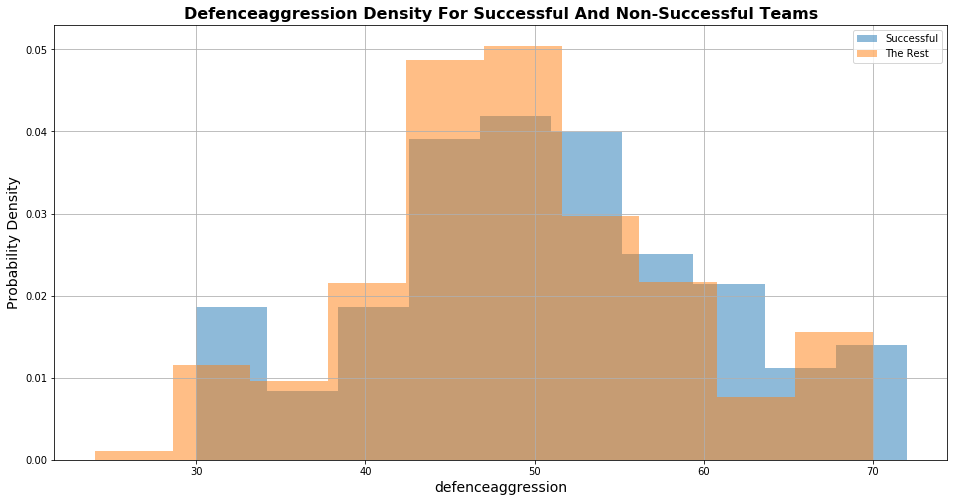

In [22]:
myHist(dfteamdata, 'defenceaggression', 'success')

#### Defense Pressure Score

Seems to be a good concentration of higher scores in sucessful teams vice the rest

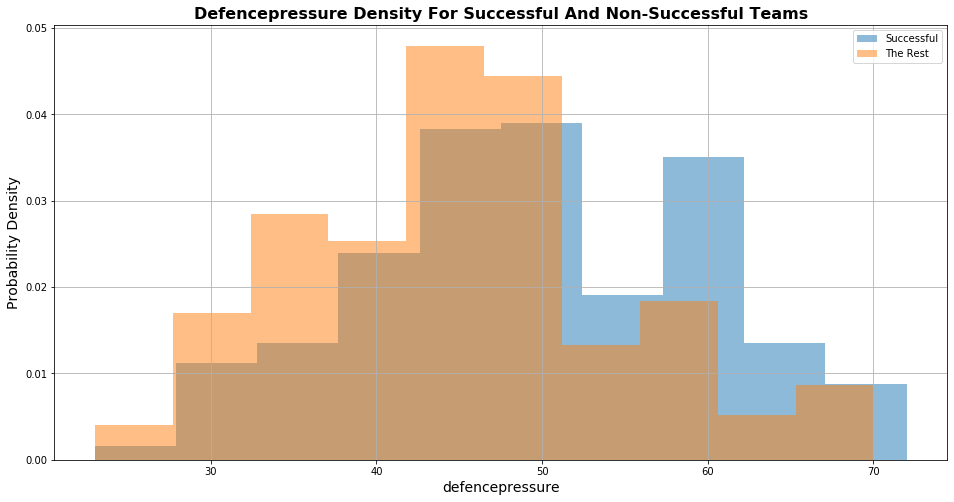

In [23]:
myHist(dfteamdata, 'defencepressure', 'success')

#### Defense Team Width Score

Again some correlation appears to be present with higher defense team width scores and successful teams.

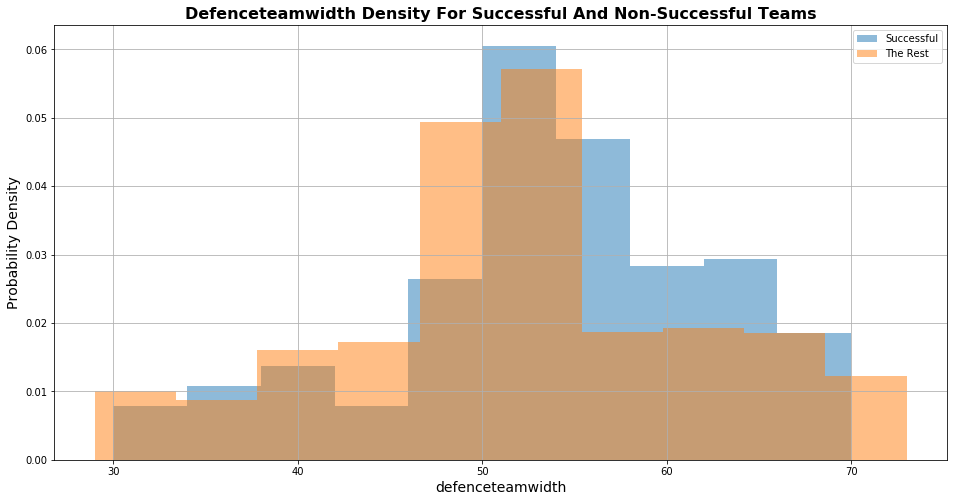

In [24]:
myHist(dfteamdata, 'defenceteamwidth', 'success')

### Conclusions for Question 1: Are there specific team attributes that "successful" teams possess
#### 1.) "If you don't shoot you don't score"
Many soccer coaches that train younger players say this often. Looking at the Chance Creation Scores, specifically the 
Chance Creation Passing and especially Chance Creation Shooting shows that successful teams have higher
scores.
#### 2.) "Defense wins championships"
In American Football "Defense wins championships" is a mantra of many broadcasters. Based on the above correlations this appears to be accurate. Successful teams had a higher density of high scores in Defense Pressure, but the Defense Aggression and Defense Team Width seemed only slightly less pronounced.

<a id='qtwo'></a>
### Research Question 2: If a characteristic identified above (in the Chance or Defense sections) changes for a team from season to season is there a corresponding change in their success?

First we'll need to identify some teams that both have successful and less than successful seasons.

In [25]:
# List some teams based on success and team names

dfteamdata.groupby(['team_name']).success.value_counts()


team_name                 success
1. FC Kaiserslautern      False      6
1. FC Köln                False      6
1. FC Nürnberg            False      6
1. FSV Mainz 05           False      5
                          True       1
AC Ajaccio                False      6
AC Arles-Avignon          False      6
AC Bellinzona             False      2
ADO Den Haag              False      6
AJ Auxerre                False      6
AS Monaco                 False      4
                          True       2
AS Nancy-Lorraine         False      6
AS Saint-Étienne          False      3
                          True       3
AZ                        False      4
                          True       2
Aberdeen                  False      4
                          True       2
Académica de Coimbra      False      6
Ajax                      True       6
Angers SCO                False      6
Arka Gdynia               False      2
Arsenal                   True       6
Aston Villa               Fals

I like Juventus, Liverpool, Milan, FC Utrecht and Paris Saint-Germain this gives us a spread of Continental teams and English teams that have both successful and less than successful seasons. Five teams should, hopefully allow us to see some tends as well.

#### Juventus
Lets start with Juventus and the Chance Creation and Defensive statistics we've defined above.

In [26]:
dfoneteam = dfteamdata[dfteamdata['team_name'] ==  'Juventus']
dfoneteam.head()

,team_name,season,buildupplayspeed,buildupplaydribbling,buildupplaypassing,chancecreationpassing,chancecreationcrossing,chancecreationshooting,defencepressure,defenceaggression,defenceteamwidth,draws,wins,losses,success
624,Juventus,2010,45,30,35,45,55,70,50,35,70,11,15,12,False
625,Juventus,2011,65,30,50,50,77,50,55,55,35,13,16,8,False
626,Juventus,2012,50,30,35,65,65,50,35,55,35,8,27,2,True
627,Juventus,2013,39,30,33,51,63,72,66,67,36,5,28,4,True
628,Juventus,2014,26,47,24,64,53,72,23,67,36,5,30,2,True


In [83]:
# Define the bar charts to be presented for each team attribute

def myBar (df, yVar):
    df.groupby('success')[yVar].mean().plot.bar()
    plt.ylabel(f'{yVar}', fontsize=14)
    plt.xlabel("Successful Team (True/False)", fontsize=14)
    plt.title(f'{yVar} mean for Successful vs Not Successful Seasons'.title(), fontsize=14, weight="bold")


In [28]:
# Define the scatter charts to be presentted for each team attribute

def myScatter (df, xVar, yVar, cVar):
    fig, ax = plt.subplots(figsize=(16,8))

    df.plot.scatter(x=xVar, y=yVar,
                    s=1200, marker="D",
                    c=df[cVar], 
                    cmap='RdYlGn', ax=ax)
    ax.set_ylabel(yVar.title(), fontsize=14)
    ax.set_xlabel(xVar.title(), fontsize=14)
    
    df[[xVar, 
        yVar,
        cVar]].apply(lambda row: ax.text(*row,fontsize=14, weight='bold',
                                        c='w',
                                        va='center',
                                        ha='center'), axis=1)
    ax.set_title(f'{yVar} by {xVar} and {cVar}'.title(),fontsize=14,weight='bold')


#### Graphing
I figured there are two graphs that should help in analyzing the data.

First a simple comparison on the means of Success and non successful seasons. This will give me a quick visual indicator on differences for those attribute we are looking at.

The second graph is showing the change in the selected score from season to season. Each point would be plotted with an indicator showing if the season was successful or not.

After showing the graph pairs for each attribute I'll sum up the conclusions I believe I can reach

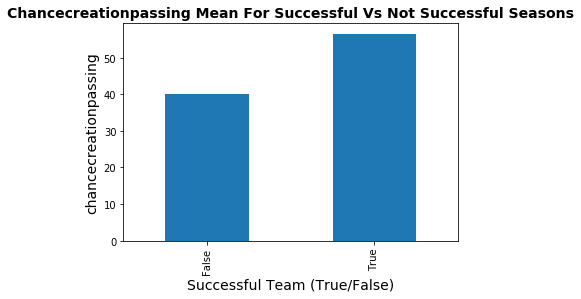

In [84]:
myBar(dfoneteam, 'chancecreationpassing')

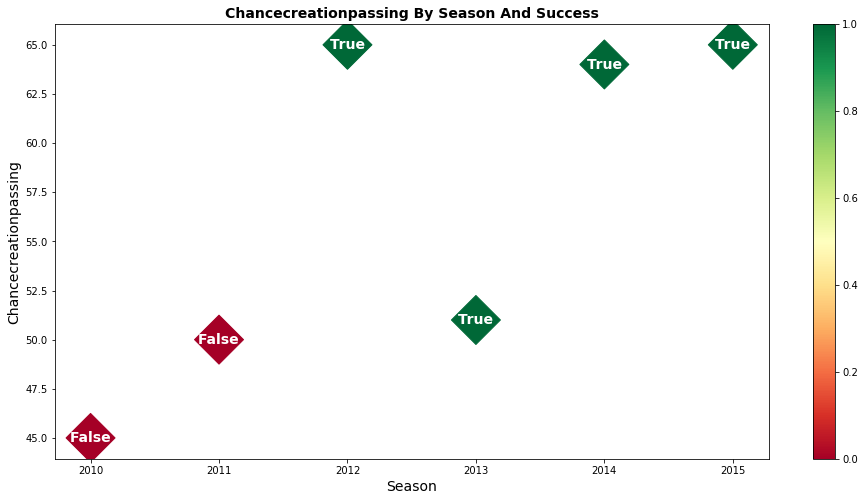

In [30]:
myScatter(dfoneteam, 'season', 'chancecreationpassing', 'success')

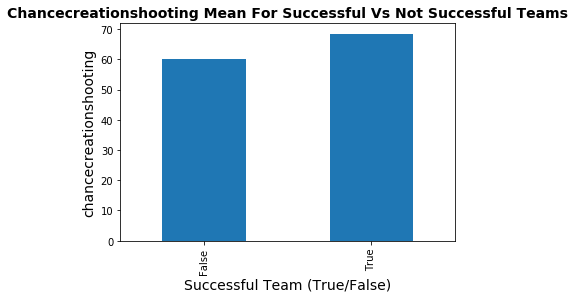

In [31]:
myBar(dfoneteam, 'chancecreationshooting')

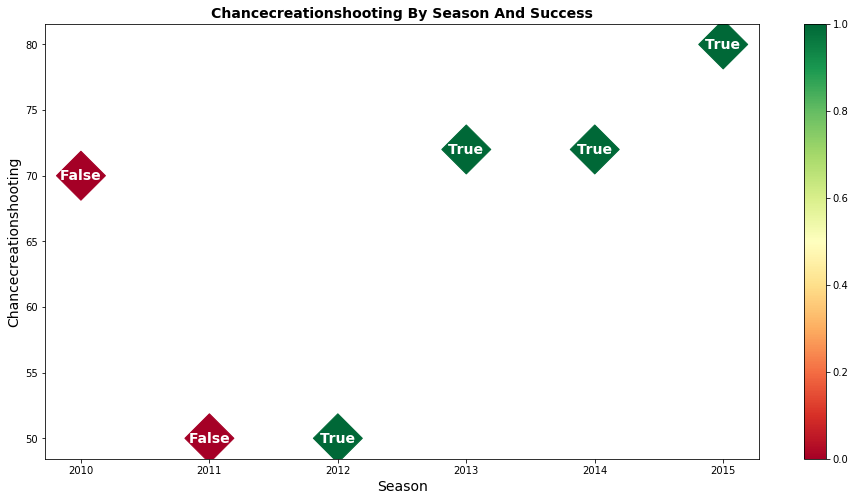

In [32]:
myScatter(dfoneteam, 'season', 'chancecreationshooting', 'success')

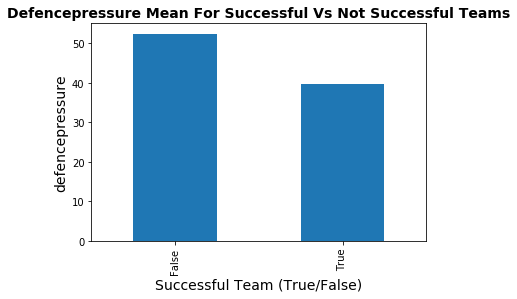

In [33]:
myBar(dfoneteam, 'defencepressure')

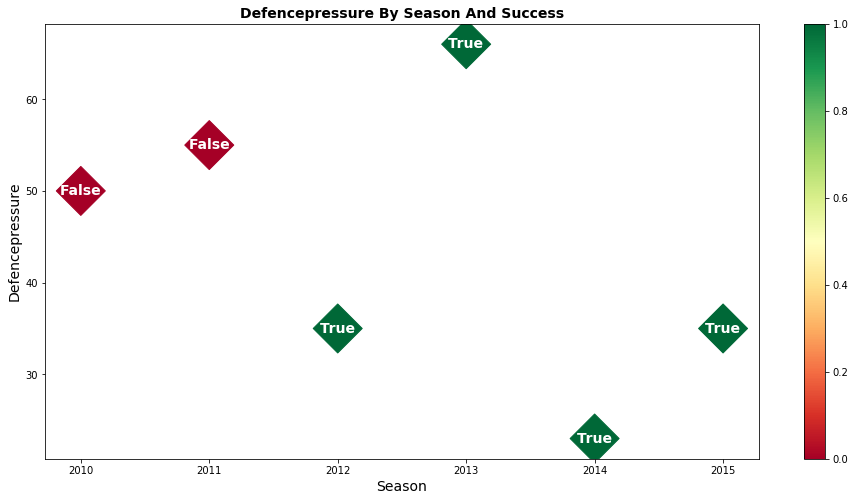

In [34]:
myScatter(dfoneteam, 'season', 'defencepressure', 'success')

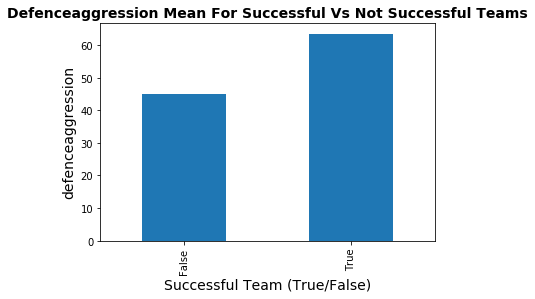

In [35]:
myBar(dfoneteam, 'defenceaggression')

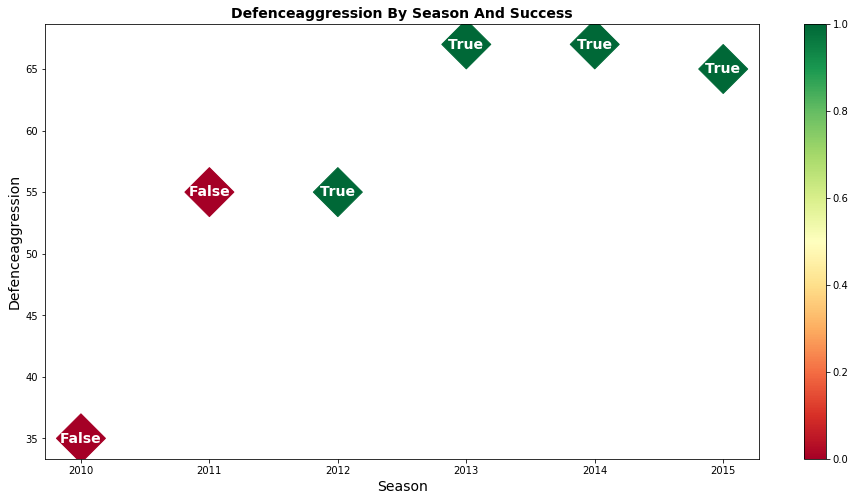

In [36]:
myScatter(dfoneteam, 'season', 'defenceaggression', 'success')

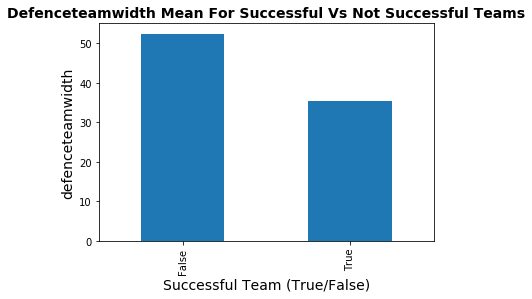

In [37]:
myBar(dfoneteam, 'defenceteamwidth')

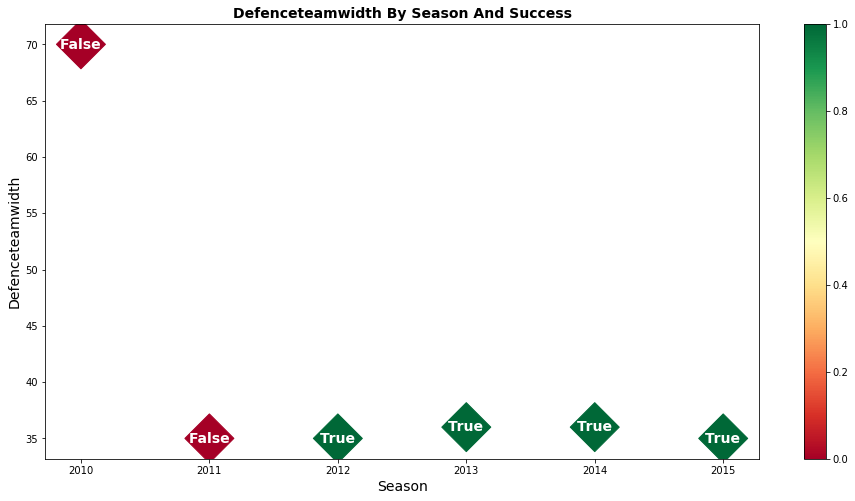

In [38]:
myScatter(dfoneteam, 'season', 'defenceteamwidth', 'success')

#### Juventus Conclusions

Based on the above Chance Creation Passing, Chance Creation Shooting and Defense Aggression had a positive effect on the
team's success. When those values went up the team was more successful

#### Liverpool
Lets move on to Liverpool and the Chance Creation and Defensive statistics we've defined above.

In [39]:
dfoneteam = dfteamdata[dfteamdata['team_name'] ==  'Liverpool']
dfoneteam.head()

,team_name,season,buildupplayspeed,buildupplaydribbling,buildupplaypassing,chancecreationpassing,chancecreationcrossing,chancecreationshooting,defencepressure,defenceaggression,defenceteamwidth,draws,wins,losses,success
742,Liverpool,2010,50,30,35,50,60,70,40,60,40,10,14,12,False
743,Liverpool,2011,60,30,50,40,45,60,55,55,50,10,20,9,True
744,Liverpool,2012,60,30,60,48,73,53,50,48,62,10,12,17,False
745,Liverpool,2013,39,30,44,42,34,54,59,52,61,9,20,8,True
746,Liverpool,2014,71,48,32,34,41,61,51,48,62,7,23,8,True


#### Graphing
I figured there are two graphs that should help in analyzing the data. 

First a simple comparison on the means of Success and non successful seasons. This will give me a quick visual indicator on differences for those attribute we are looking at.

The second graph is showing the change in the selected score from season to season. Each point would be plotted with an indicator showing if the season was successful or not.

After showing the graph pairs for each attribute I'll sum up the conclusions I believe I can reach

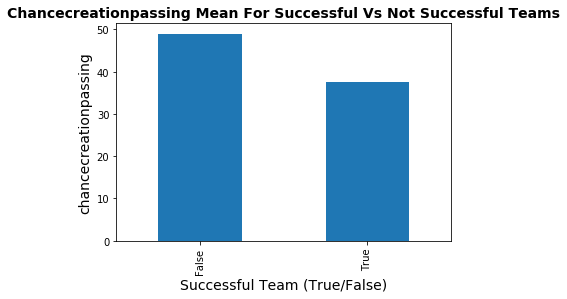

In [40]:
myBar(dfoneteam, 'chancecreationpassing')

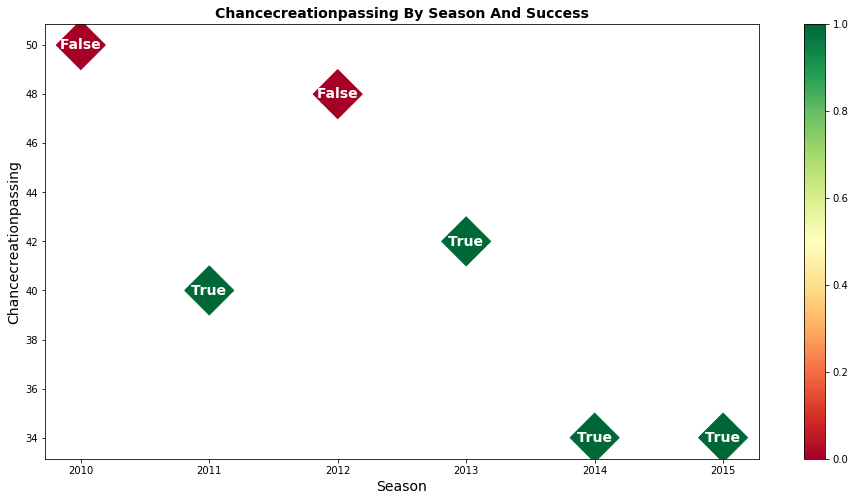

In [41]:
myScatter(dfoneteam, 'season', 'chancecreationpassing', 'success')

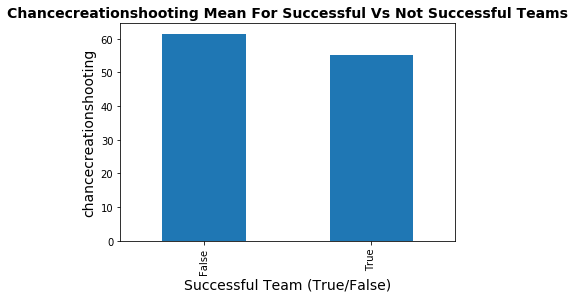

In [42]:
myBar(dfoneteam, 'chancecreationshooting')

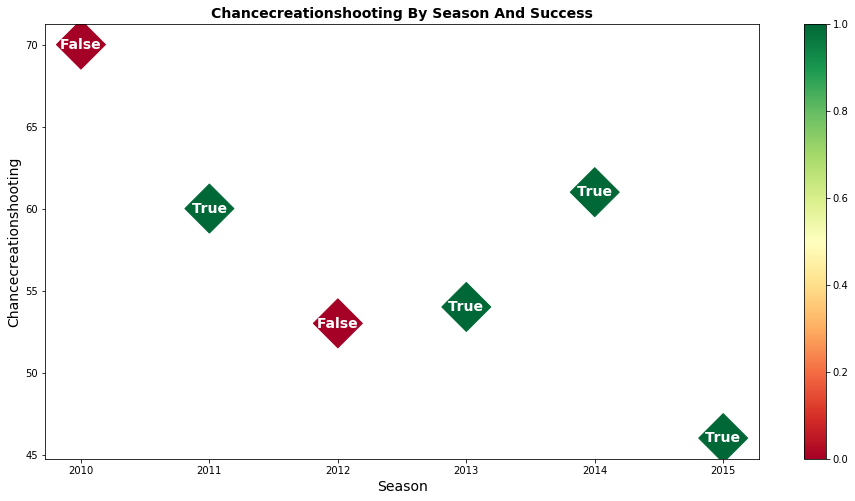

In [43]:
myScatter(dfoneteam, 'season', 'chancecreationshooting', 'success')

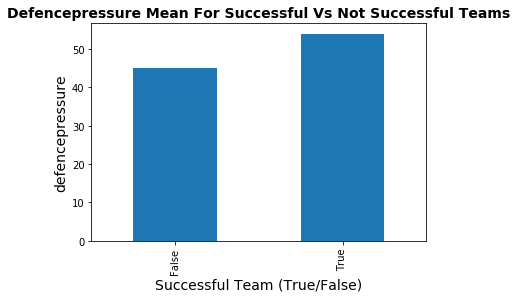

In [44]:
myBar(dfoneteam, 'defencepressure')

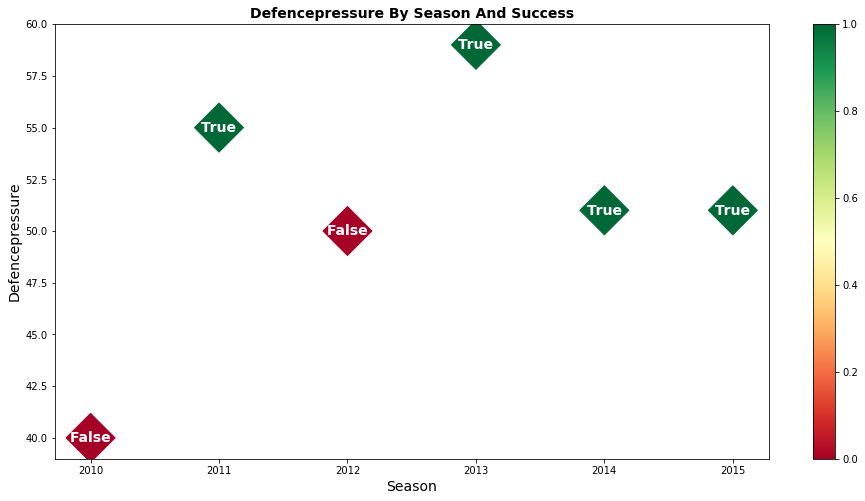

In [45]:
myScatter(dfoneteam, 'season', 'defencepressure', 'success')

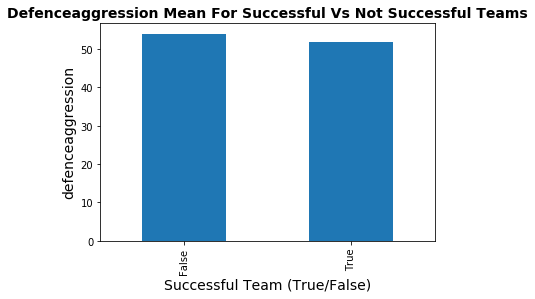

In [46]:
myBar(dfoneteam, 'defenceaggression')

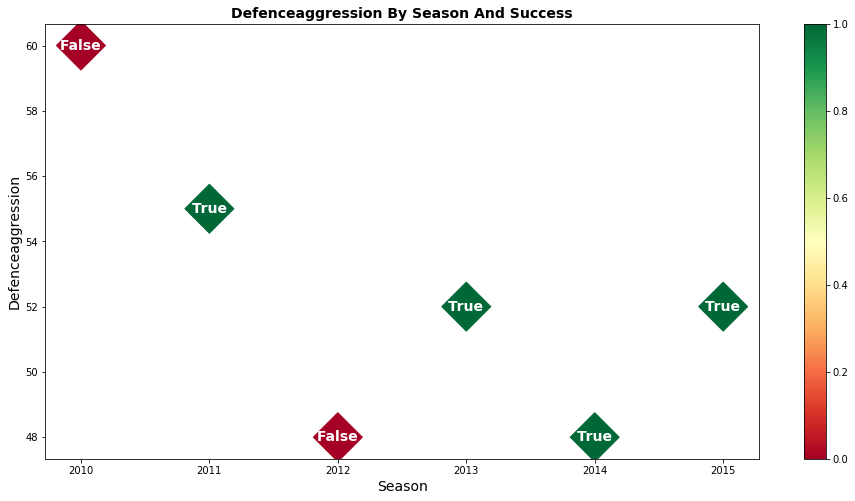

In [47]:
myScatter(dfoneteam, 'season', 'defenceaggression', 'success')

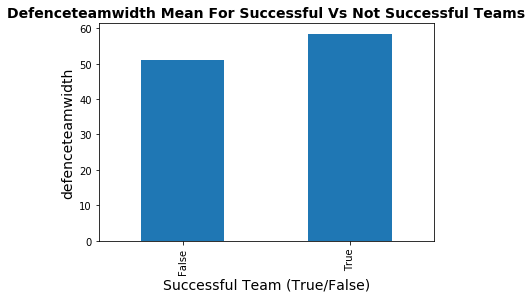

In [48]:
myBar(dfoneteam, 'defenceteamwidth')

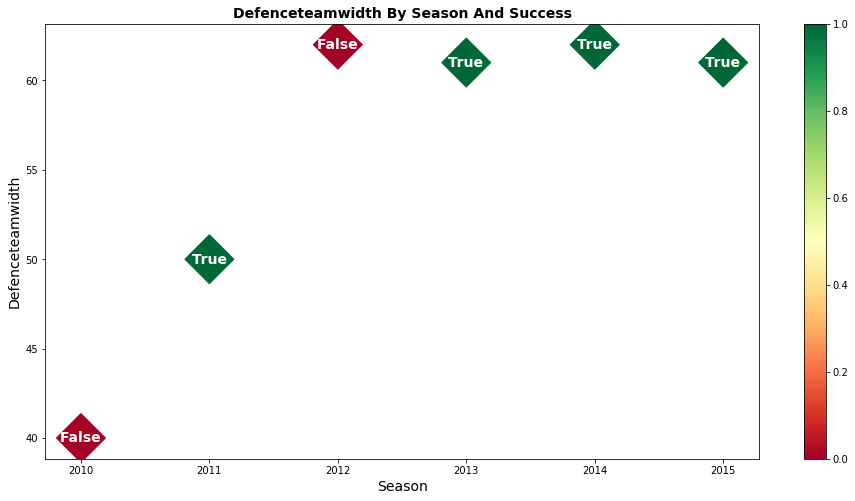

In [49]:
myScatter(dfoneteam, 'season', 'defenceteamwidth', 'success')

#### Liverpool Conclusions

Unlike Juventus, Liverpool improved their Defense Team Width, but also had improved Chance Creation Shooting and Defense Aggression. The is some problematic data, though, as some of the values previously identified went down, particularly the Chance Creation Passing. This could be noise from the limited data set or more indicative of a problem in the hypothesis.

#### Milan
Lets move on to Milan and the Chance Creation and Defensive statistics we've defined above.

In [50]:
dfoneteam = dfteamdata[dfteamdata['team_name'] ==  'Milan']
dfoneteam.head()

,team_name,season,buildupplayspeed,buildupplaydribbling,buildupplaypassing,chancecreationpassing,chancecreationcrossing,chancecreationshooting,defencepressure,defenceaggression,defenceteamwidth,draws,wins,losses,success
15,Milan,2010,45,30,30,55,45,70,30,35,60,9,22,8,True
16,Milan,2011,65,30,50,50,60,50,50,50,50,11,23,3,True
17,Milan,2012,45,30,50,65,20,50,45,45,50,7,21,11,True
18,Milan,2013,48,30,54,51,53,64,48,49,53,13,17,7,True
19,Milan,2014,48,70,52,66,36,75,58,57,49,9,18,10,True


#### Graphing
I figured there are two graphs that should help in analyzing the data. 

First a simple comparison on the means of Success and non successful seasons. This will give me a quick visual indicator on differences for those attribute we are looking at.

The second graph is showing the change in the selected score from season to season. Each point would be plotted with an indicator showing if the season was successful or not.

After showing the graph pairs for each attribute I'll sum up the conclusions I believe I can reach

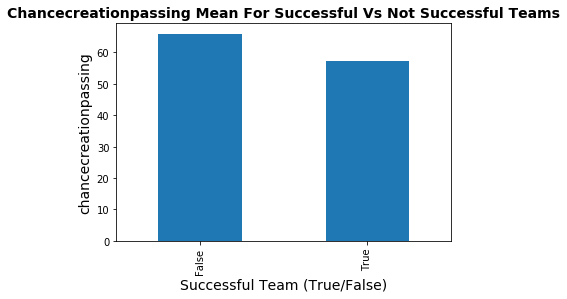

In [51]:
myBar(dfoneteam, 'chancecreationpassing')

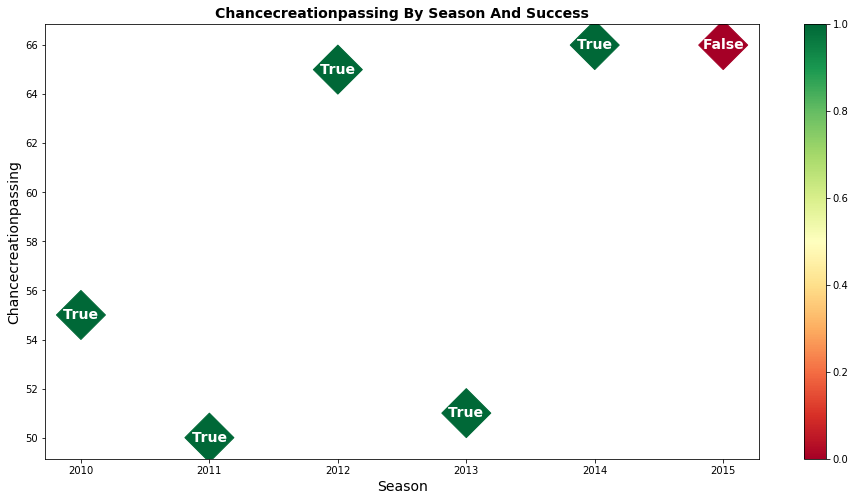

In [52]:
myScatter(dfoneteam, 'season', 'chancecreationpassing', 'success')

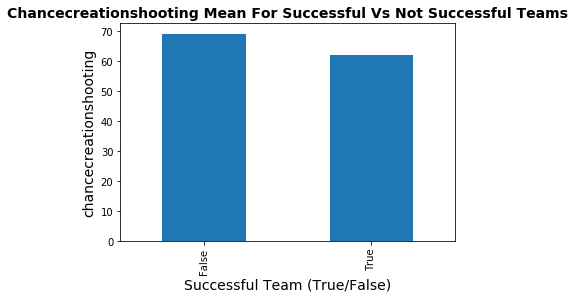

In [53]:
myBar(dfoneteam, 'chancecreationshooting')

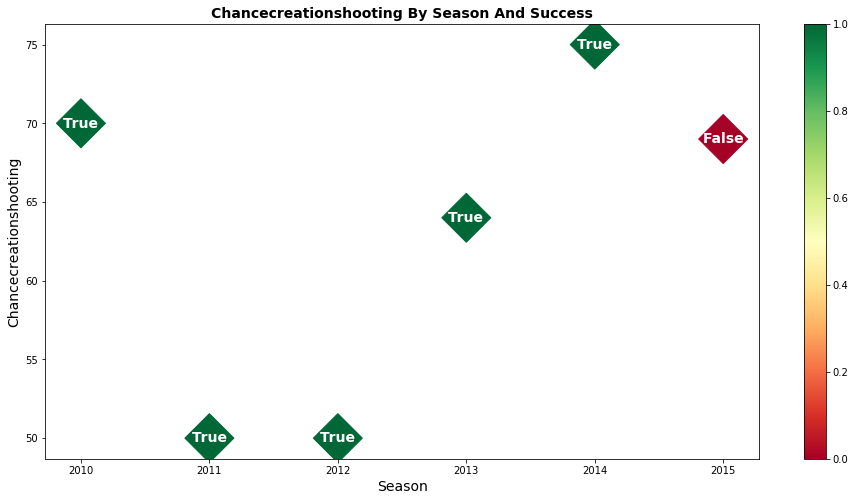

In [54]:
myScatter(dfoneteam, 'season', 'chancecreationshooting', 'success')

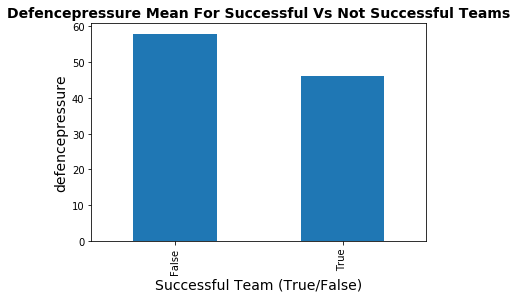

In [55]:
myBar(dfoneteam, 'defencepressure')

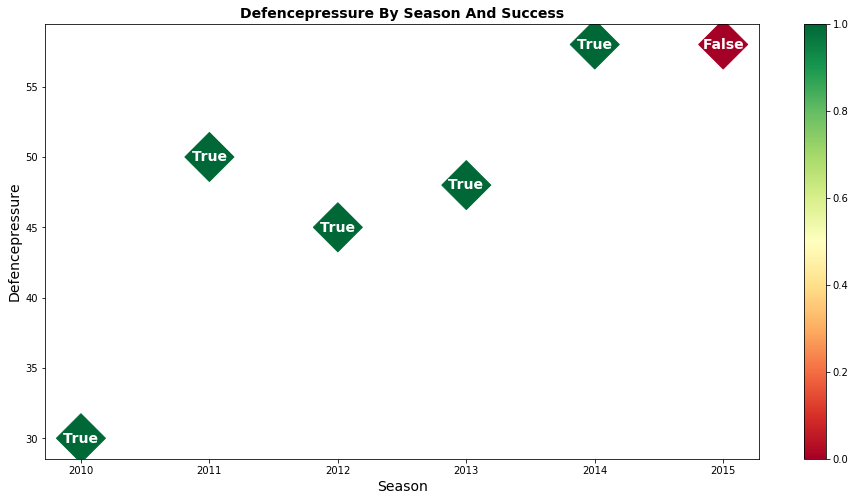

In [56]:
myScatter(dfoneteam, 'season', 'defencepressure', 'success')

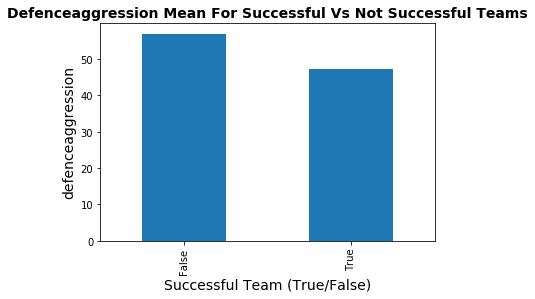

In [57]:
myBar(dfoneteam, 'defenceaggression')

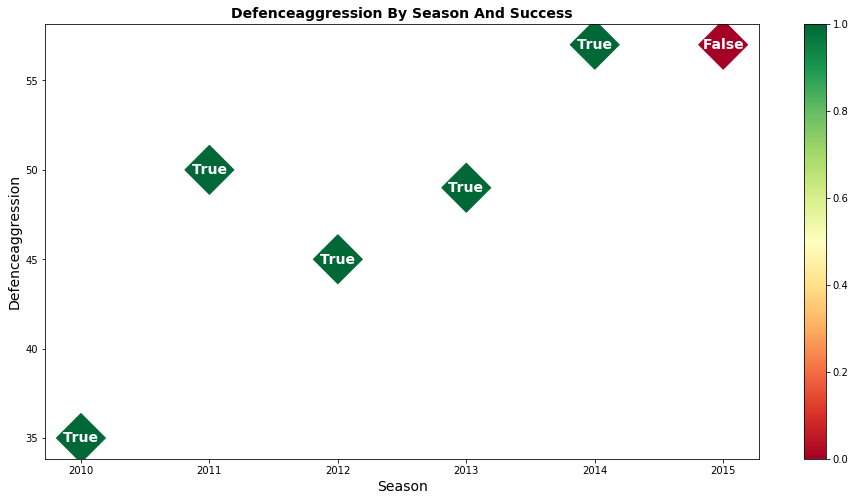

In [58]:
myScatter(dfoneteam, 'season', 'defenceaggression', 'success')

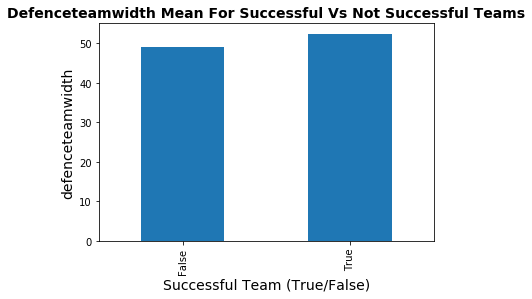

In [59]:
myBar(dfoneteam, 'defenceteamwidth')

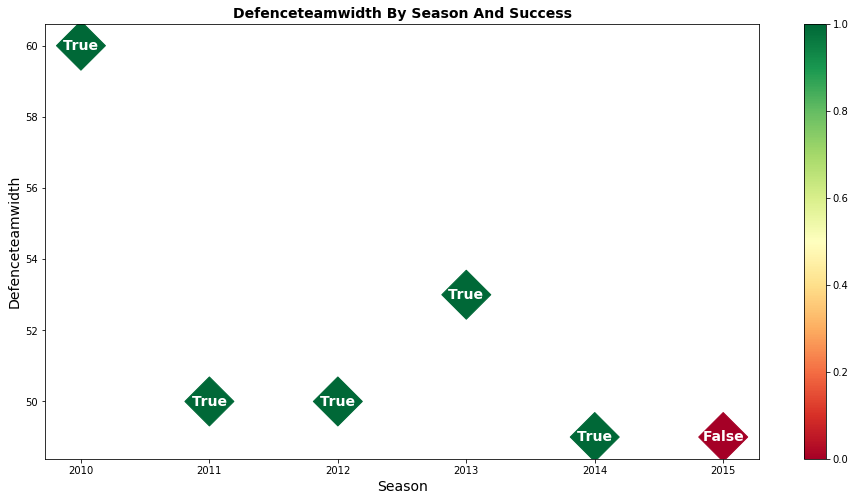

In [60]:
myScatter(dfoneteam, 'season', 'defenceteamwidth', 'success')

#### Milan Conclusions

Milan has problematic data. It is a successful team (top 20%) but has consistantly lower scores for team attributes with the exception of defense team width.

#### FC Utrecht
We'll move over too FC Utrecht to view the same Chance Creation and Defensive statistics we've defined above.

In [61]:
dfoneteam = dfteamdata[dfteamdata['team_name'] ==  'FC Utrecht']
dfoneteam.head()

,team_name,season,buildupplayspeed,buildupplaydribbling,buildupplaypassing,chancecreationpassing,chancecreationcrossing,chancecreationshooting,defencepressure,defenceaggression,defenceteamwidth,draws,wins,losses,success
438,FC Utrecht,2010,45,30,45,33,50,67,30,30,30,7,14,14,False
439,FC Utrecht,2011,66,30,45,41,69,72,34,57,34,11,9,13,False
440,FC Utrecht,2012,47,30,52,52,54,52,45,49,47,11,15,9,False
441,FC Utrecht,2013,47,30,52,52,54,60,45,49,47,3,18,13,True
442,FC Utrecht,2014,50,50,52,55,49,52,45,49,47,7,11,15,False


#### Graphing
I figured there are two graphs that should help in analyzing the data. 

First a simple comparison on the means of Success and non successful seasons. This will give me a quick visual indicator on differences for those attribute we are looking at.

The second graph is showing the change in the selected score from season to season. Each point would be plotted with an indicator showing if the season was successful or not.

After showing the graph pairs for each attribute I'll sum up the conclusions I believe I can reach

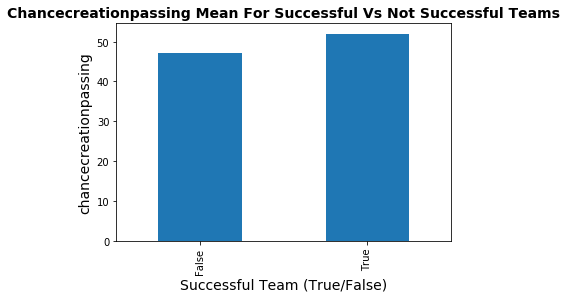

In [62]:
myBar(dfoneteam, 'chancecreationpassing')

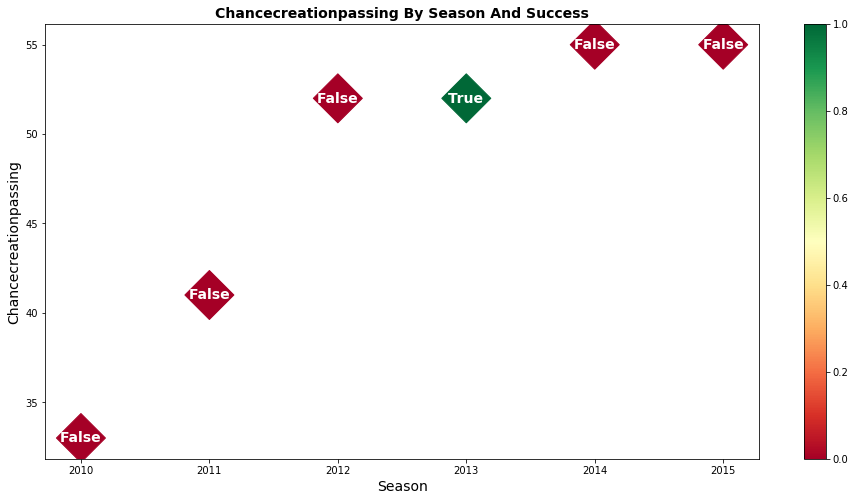

In [63]:
myScatter(dfoneteam, 'season', 'chancecreationpassing', 'success')

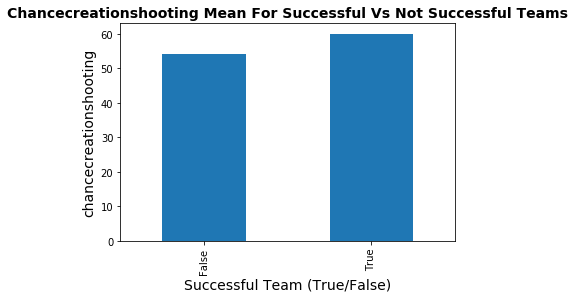

In [64]:
myBar(dfoneteam, 'chancecreationshooting')

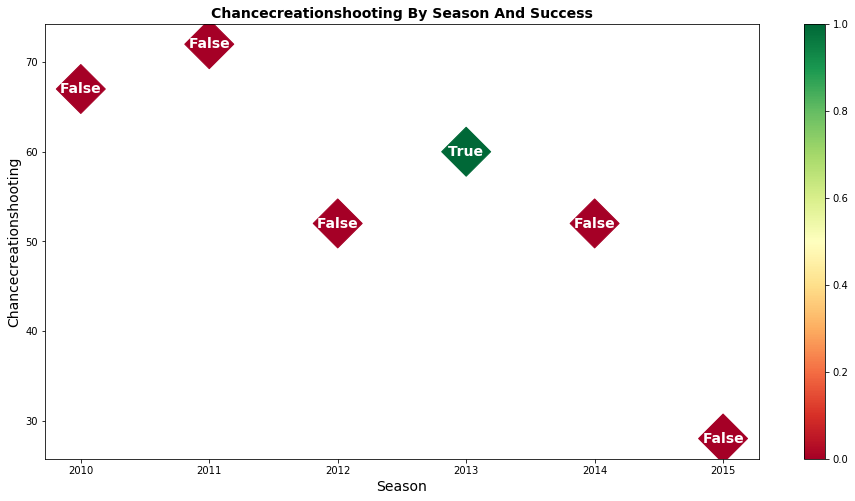

In [65]:
myScatter(dfoneteam, 'season', 'chancecreationshooting', 'success')

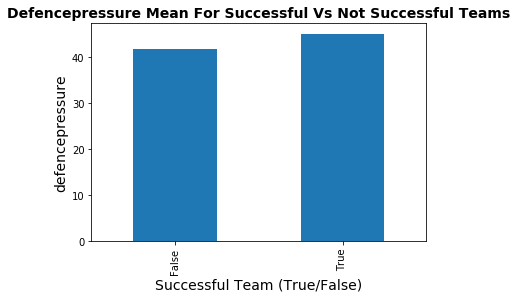

In [66]:
myBar(dfoneteam, 'defencepressure')

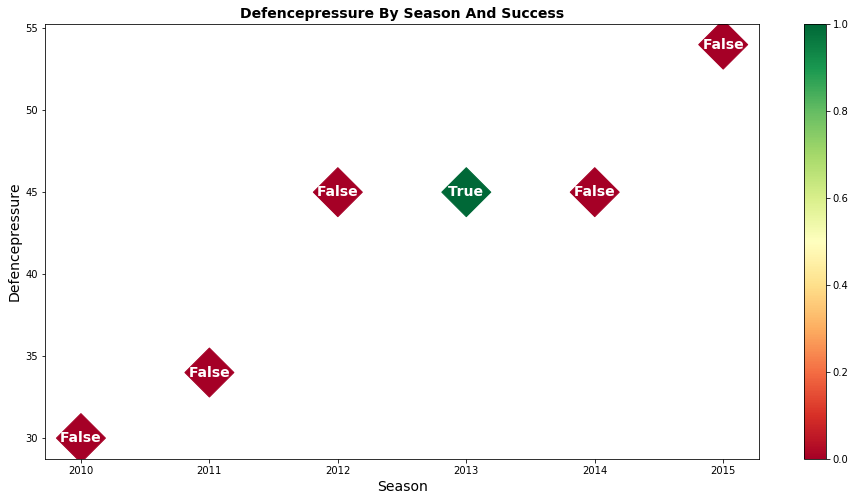

In [67]:
myScatter(dfoneteam, 'season', 'defencepressure', 'success')

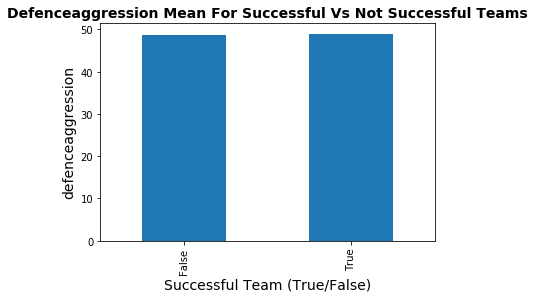

In [68]:
myBar(dfoneteam, 'defenceaggression')

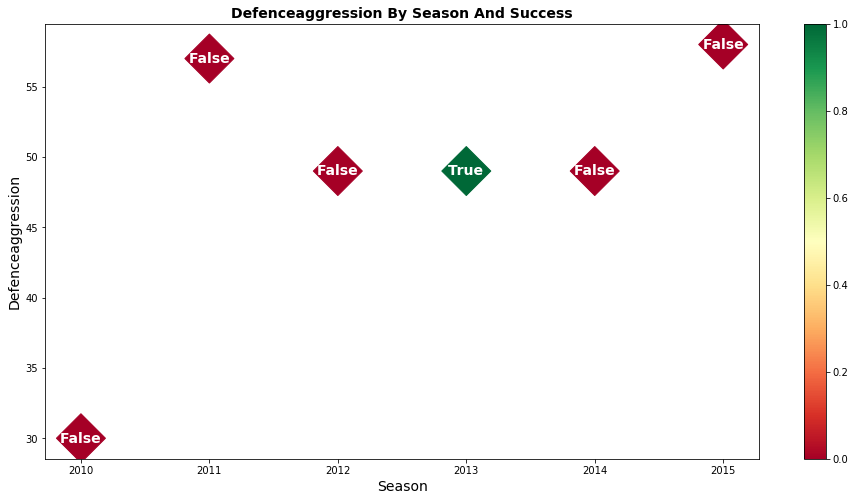

In [69]:
myScatter(dfoneteam, 'season', 'defenceaggression', 'success')

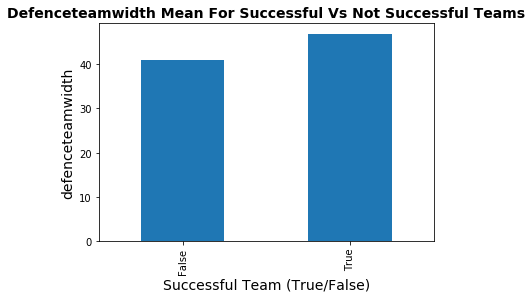

In [70]:
myBar(dfoneteam, 'defenceteamwidth')

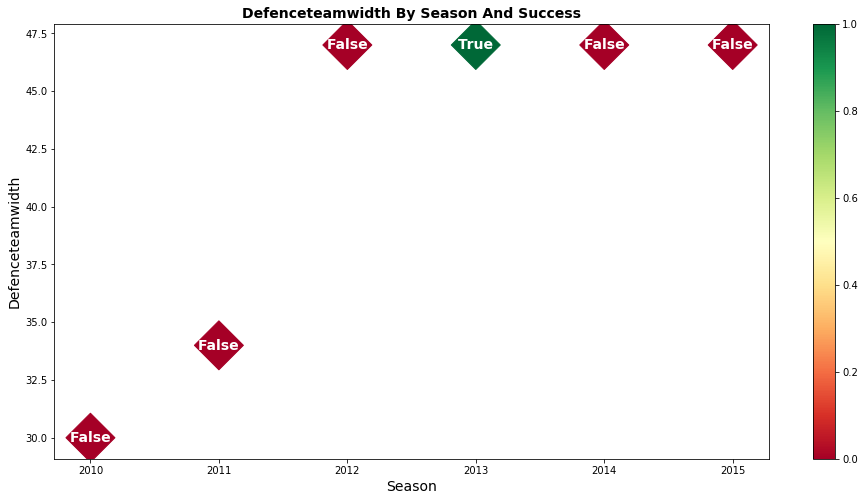

In [71]:
myScatter(dfoneteam, 'season', 'defenceteamwidth', 'success')

#### FC Utrecht Conclusions

FC Utrecht is somewhat problematic. They do not really improve much in their one successful season, except mildly in Chance Creation Shooting. I'm not sure we can make any conclusions here.

#### Paris Saint-Germain

Finally we'll move over to Newcastle United for the Chance Creation and Defensive statistics.

In [72]:
dfoneteam = dfteamdata[dfteamdata['team_name'] ==  'Paris Saint-Germain']
dfoneteam.head()

,team_name,season,buildupplayspeed,buildupplaydribbling,buildupplaypassing,chancecreationpassing,chancecreationcrossing,chancecreationshooting,defencepressure,defenceaggression,defenceteamwidth,draws,wins,losses,success
961,Paris Saint-Germain,2010,50,30,65,40,65,55,70,70,70,13,12,13,False
962,Paris Saint-Germain,2011,35,30,35,35,35,50,45,55,65,12,19,7,True
963,Paris Saint-Germain,2012,49,30,41,62,52,60,49,46,52,11,22,5,True
964,Paris Saint-Germain,2013,49,30,41,62,52,60,49,46,52,8,27,3,True
965,Paris Saint-Germain,2014,49,70,55,62,61,68,57,53,56,11,24,3,True


#### Graphing
I figured there are two graphs that should help in analyzing the data. 

First a simple comparison on the means of Success and non successful seasons. This will give me a quick visual indicator on differences for those attribute we are looking at.

The second graph is showing the change in the selected score from season to season. Each point would be plotted with an indicator showing if the season was successful or not.

After showing the graph pairs for each attribute I'll sum up the conclusions I believe I can reach

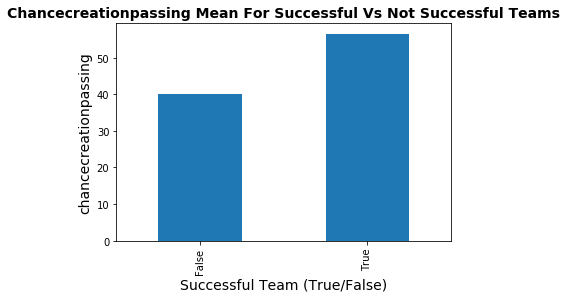

In [73]:
myBar(dfoneteam, 'chancecreationpassing')

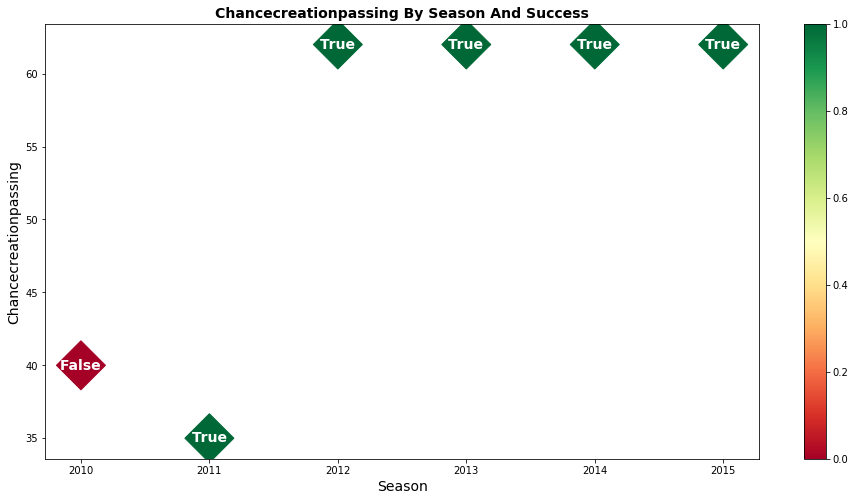

In [74]:
myScatter(dfoneteam, 'season', 'chancecreationpassing', 'success')

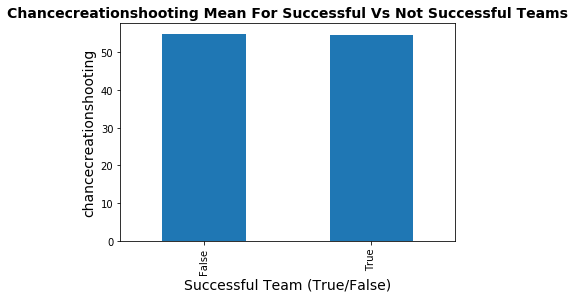

In [75]:
myBar(dfoneteam, 'chancecreationshooting')

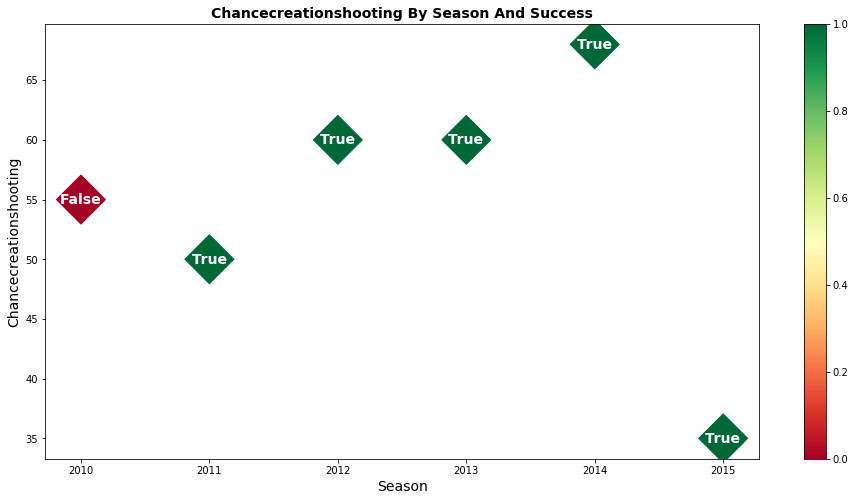

In [76]:
myScatter(dfoneteam, 'season', 'chancecreationshooting', 'success')

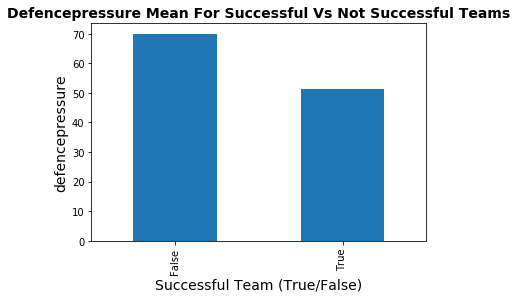

In [77]:
myBar(dfoneteam, 'defencepressure')

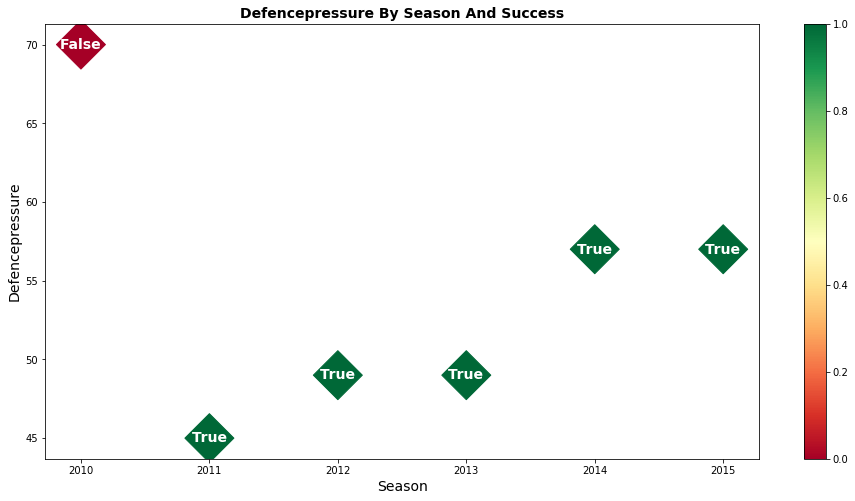

In [78]:
myScatter(dfoneteam, 'season', 'defencepressure', 'success')

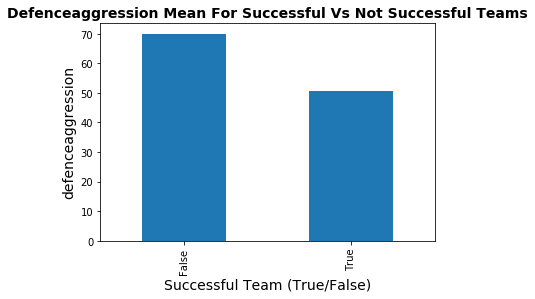

In [79]:
myBar(dfoneteam, 'defenceaggression')

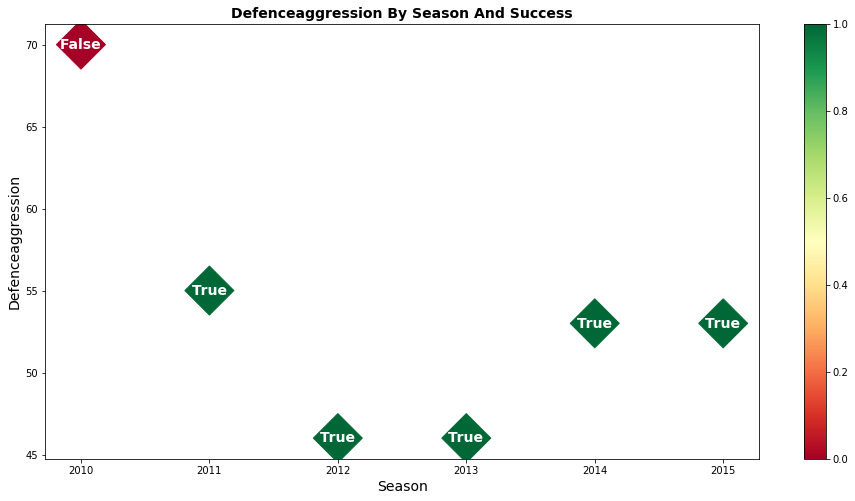

In [80]:
myScatter(dfoneteam, 'season', 'defenceaggression', 'success')

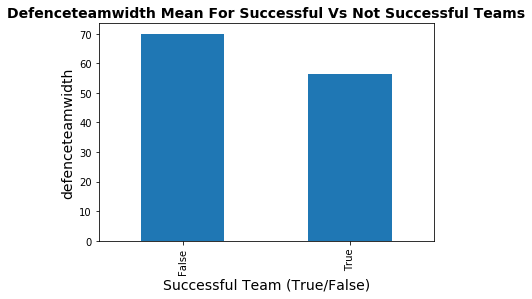

In [81]:
myBar(dfoneteam, 'defenceteamwidth')

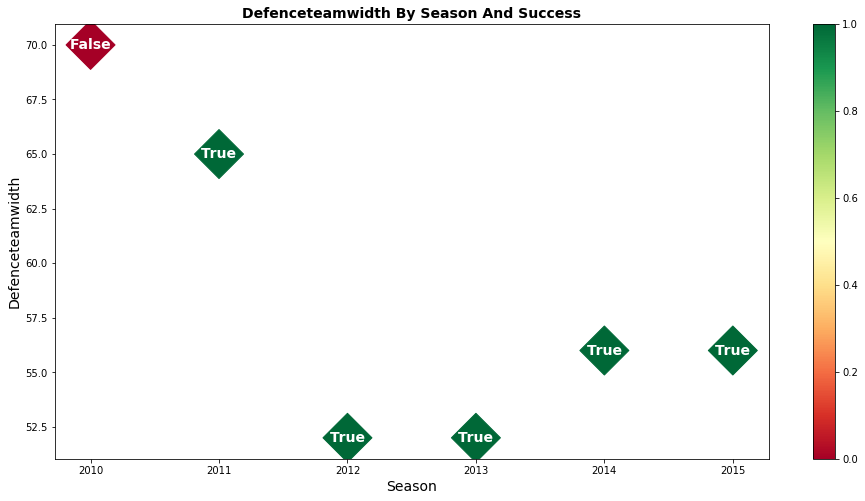

In [82]:
myScatter(dfoneteam, 'season', 'defenceteamwidth', 'success')

#### Paris Saint-Germain Conclusions
Paris Saint-Germain shows stronger Passing and Shooting scores but their defense is lagging. Again, not a good indicator of our hypothesis.

### Conclusions for Question 2: If a characteristic identified above (in the Chance or Defense sections) changes for a team from season to season is there a corresponding change in their success?
Looking at the data above, I don't feel comfortable drawing conclusions on the hypothesis that improving any specific characterisic or attribute of a team results in success. The trends appear very noisy. This could be because when filtering down the team level we get much less data to draw trends from, or that the statistics themselves are not relevant to the question. 

One variable I haven't been able to account for in the data was relegation and its effects. It is entirely possible that some of the team's success or lack there of could be attributeable to the relegation process in certain leagues where if they finish in the bottom of the league the team is moved down to a more junior division, while successful teams are relegated up to the senior divisions. There is no data regarding this process that I could find.



<a id='conclusions'></a>
## Conclusions

I believe the first question posed seems to hold up, some attribute do appear to correlate to success, particularly the Chance Creaton and Defense attributes.

These break down a bit in per team analysis, either because of limited data or noisiness in the data.

If I were to do further analysis I might look at pairing some statistics to see if the combination resulted in any change. I might also adjust the definition of success. Originally I used more wins than losses, but that didn't make good sense to me, but more wins than losses and draws combined (to cover teams in the data that had shorter seasons than captured in the 80th Percentile). I could also look at individual performance of players.
